# Imports & Data

In [1]:
import pandas as pd
import numpy as np

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import matplotlib.pyplot as plt 
import seaborn as sns 

# Load Data

In [2]:
# Load preprocessed data

sample = pd.read_csv("/workspaces/ERP_Newsletter/data_processed/sample_300_full.csv")
labels = pd.read_csv("/workspaces/ERP_Newsletter/data_processed/sample_llm_prelabeled.csv")

print(f"Loaded {len(labels)} rows")
print(f"Loaded {len(sample)} rows")

sample.columns

Loaded 300 rows
Loaded 300 rows


Index(['id', 'newsletter_number', 'issue_date', 'new_theme', 'text', 'domain',
       'organisation', 'org_group', 'year_quarter'],
      dtype='object')

In [3]:
#merge
labels = labels.rename(columns={"doc_id": "id"})

In [9]:
df = pd.merge(sample, labels, on=["id", "text"], how="inner")
print(f"Merged dataset shape: {df.shape}")
print("Columns:", df.columns.tolist())

Merged dataset shape: (300, 12)
Columns: ['id', 'newsletter_number', 'issue_date', 'new_theme', 'text', 'domain', 'organisation', 'org_group', 'year_quarter', 'llm_label', 'llm_confidence', 'llm_rationale']


In [5]:
keep_cols = [
    "id",
    "text",
    "new_theme",
    "organisation",
    "org_group",
    "year_quarter",
    "llm_label",
    "llm_confidence"
]

df = df[keep_cols].copy()

print(f"✅ Columns retained: {keep_cols}")

✅ Columns retained: ['id', 'text', 'new_theme', 'organisation', 'org_group', 'year_quarter', 'llm_label', 'llm_confidence']


# Light Preprocessing

In [11]:
df['text_clean'] = df['text'].fillna('')  # Ensure no NaNs

In [12]:
#remove URLs 
df['text_clean'] = df['text_clean'].str.replace(
    r'http\S+|www\S+', '', regex=True
).str.strip()

In [13]:
# Check text lengths (VADER works better on sentences/paragraphs)
print(df['text_clean'].str.split().str.len().describe())

count    300.000000
mean      42.133333
std       21.375029
min        6.000000
25%       26.000000
50%       37.000000
75%       52.000000
max      125.000000
Name: text_clean, dtype: float64


# VADER MODEL 

In [16]:
# VADER Model 
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text): 
    scores = analyzer.polarity_scores(str(text))
    return pd.Series({
        'vader_neg': scores['neg'],
        'vader_neu': scores['neu'],
        'vader_pos': scores['pos'],
        'vader_compound': scores['compound']
    })

In [17]:
# Apply VADER to all texts 
vader_scores = df['text_clean'].apply(analyze_sentiment)
df = df.join(vader_scores)

In [19]:
# Create sentiment labels based on compound score
def get_label(compound_score): 
    if compound_score >= 0.05: 
        return 'positive'
    elif compound_score <= -0.05: 
        return 'critical'
    else: 
        return 'neutral'

df['vader_label'] = df['vader_compound'].apply(get_label)

# Save Results 

In [20]:
output_path = "/workspaces/ERP_Newsletter/data_processed/full_dataset_with_vader.csv"
df.to_csv(output_path, index=False)
print(f"Saved results in {output_path}")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Saved results in /workspaces/ERP_Newsletter/data_processed/full_dataset_with_vader.csv


# Evaluate Performance 

In [25]:
#Basic stats
print(f"\n*Label Distribution*:")
print("\nVADER predictions:")
print(df['vader_label'].value_counts())
print("\nLLM ground truth:")
print(df['llm_label'].value_counts())


*Label Distribution*:

VADER predictions:
vader_label
positive    156
critical     81
neutral      63
Name: count, dtype: int64

LLM ground truth:
llm_label
neutral     213
critical     48
positive     39
Name: count, dtype: int64


In [26]:
#Performance metrics 
print(classification_report(df['llm_label'], df['vader_label']))

              precision    recall  f1-score   support

    critical       0.38      0.65      0.48        48
     neutral       0.90      0.27      0.41       213
    positive       0.21      0.85      0.34        39

    accuracy                           0.40       300
   macro avg       0.50      0.59      0.41       300
weighted avg       0.73      0.40      0.41       300



In [30]:
#Accuracy 
acc = accuracy_score(df['llm_label'], df['vader_label'])
print(f"\n Overall Accuracy: {acc:.2%}")


 Overall Accuracy: 40.33%


In [31]:
#F1 scores by class 
f1_macro = f1_score(df['llm_label'], df['vader_label'], average='macro')
f1_weighted = f1_score(df['llm_label'], df['vader_label'], average='weighted')
print(f"   Macro F1: {f1_macro:.3f}")
print(f"   Weighted F1: {f1_weighted:.3f}")

   Macro F1: 0.411
   Weighted F1: 0.414


# Visualisations

<Figure size 600x500 with 0 Axes>

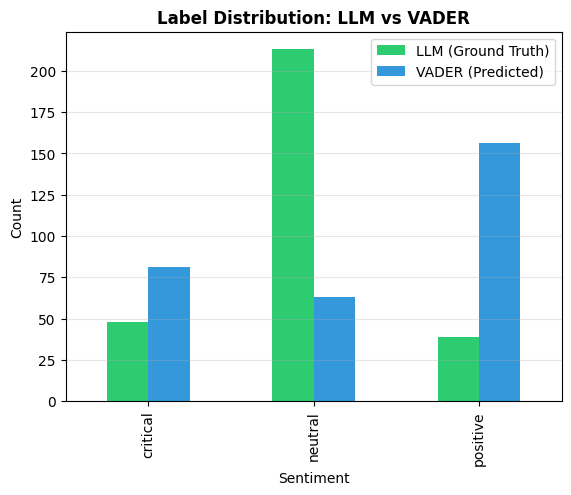

In [37]:
# --- Plot 1: Label Distribution Comparison ---
plt.figure(figsize=(6, 5))
label_counts = pd.DataFrame({
    'LLM (Ground Truth)': df['llm_label'].value_counts(),
    'VADER (Predicted)': df['vader_label'].value_counts()
})
label_counts.plot(kind='bar', color=['#2ecc71', '#3498db'])
plt.title('Label Distribution: LLM vs VADER', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

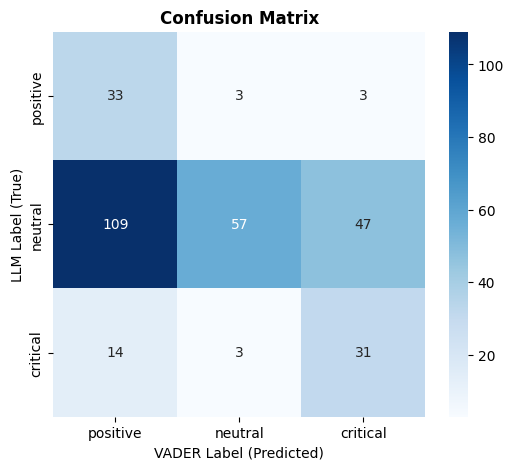

In [38]:
# --- Plot 2: Confusion Matrix ---
plt.figure(figsize=(6, 5))
cm = confusion_matrix(df['llm_label'], df['vader_label'],
                      labels=['positive', 'neutral', 'critical'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'neutral', 'critical'],
            yticklabels=['positive', 'neutral', 'critical'])
plt.title('Confusion Matrix', fontsize=12, fontweight='bold')
plt.ylabel('LLM Label (True)')
plt.xlabel('VADER Label (Predicted)')
plt.show()

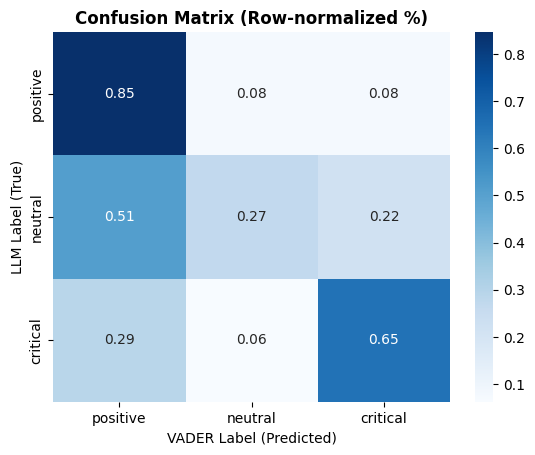

In [44]:
# Compute confusion matrix with normalization by row
cm = confusion_matrix(
    df['llm_label'],
    df['vader_label'],
    labels=['positive', 'neutral', 'critical'],
    normalize='true'  # normalizes each row to sum to 1
)

sns.heatmap(
    cm, annot=True, fmt='.2f', cmap='Blues',
    xticklabels=['positive', 'neutral', 'critical'],
    yticklabels=['positive', 'neutral', 'critical']
)

plt.title('Confusion Matrix (Row-normalized %)', fontsize=12, fontweight='bold')
plt.ylabel('LLM Label (True)')
plt.xlabel('VADER Label (Predicted)')
plt.show()

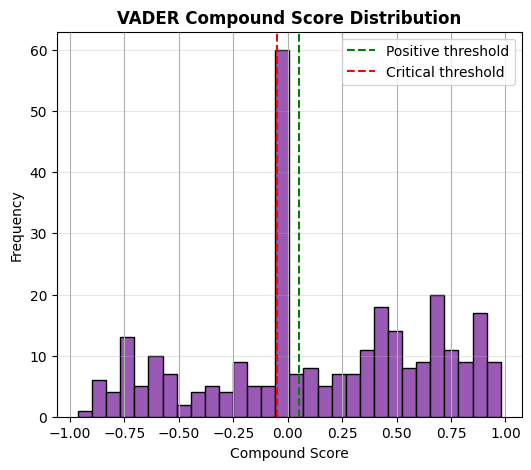

In [39]:
# --- Plot 3: VADER Compound Score Distribution ---
plt.figure(figsize=(6, 5))
df['vader_compound'].hist(bins=30, color='#9b59b6', edgecolor='black')
plt.axvline(0.05, color='green', linestyle='--', label='Positive threshold')
plt.axvline(-0.05, color='red', linestyle='--', label='Critical threshold')
plt.title('VADER Compound Score Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

<Figure size 600x500 with 0 Axes>

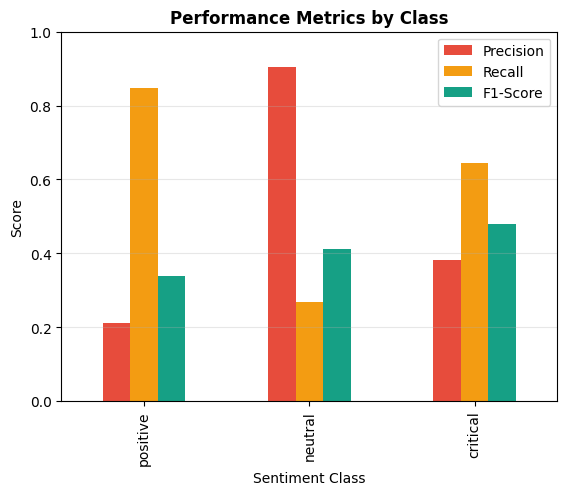

In [40]:
# --- Plot 4: Precision, Recall, F1 by Class ---
plt.figure(figsize=(6, 5))
report = classification_report(df['llm_label'], df['vader_label'], output_dict=True)
classes = ['positive', 'neutral', 'critical']
metrics_df = pd.DataFrame({
    'Precision': [report[c]['precision'] for c in classes],
    'Recall': [report[c]['recall'] for c in classes],
    'F1-Score': [report[c]['f1-score'] for c in classes]
}, index=classes)
metrics_df.plot(kind='bar', color=['#e74c3c', '#f39c12', '#16a085'])
plt.title('Performance Metrics by Class', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xlabel('Sentiment Class')
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()


# Sample predictions

In [47]:
sample_results = df[['text', 'llm_label', 'vader_label', 'vader_compound']].head(-3)

for idx, row in sample_results.iterrows():
    print(f"\n{idx+1}. 📰 Text:\n{row['text']}\n")
    print(f"   ➤ LLM: {row['llm_label']:<10} | VADER: {row['vader_label']:<10} | Score: {row['vader_compound']:.3f}")


1. 📰 Text:
FCDO - Foreign Secretary to call for international cooperation to manage the global implications of AI Foreign Secretary to chair first ever UN Security Council session on AI https://www.gov.uk/government/news/foreign-secretary-to-call-for-international-cooperation-to-manage-the-global-implications-of-artificial-intelligence?utm_medium=email&utm_campaign=govuk-notifications-topic&utm_source=7a20d888-ea19-4348-8ec2-d32042ad5788&utm_content=daily

   ➤ LLM: neutral    | VADER: positive   | Score: 0.340

2. 📰 Text:
ChatGPT isn't the death of homework – just an opportunity for schools to do things differently The UK government has launched a consultation on the use of generative AI in education, following the publication of initial guidance on how schools might make best use of this technology. https://theconversation.com/chatgpt-isnt-the-death-of-homework-just-an-opportunity-for-schools-to-do-things-differently-205053?utm_medium=email&utm_campaign=Latest%20from%20The%20Convers